In [46]:
import json
import re
import os
import jieba
import copy
import glob
import numpy as np
import random
import pandas as pd
import torch

In [126]:
from transformers import BertTokenizer
pretrained_model_path = "/Users/zeyesun/Documents/Data/bert/roberta_large"
tokenizer = BertTokenizer.from_pretrained(pretrained_model_path, do_lower_case=True)
tokenizer.do_basic_tokenize = False

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [144]:
# t = " ".join(jieba.cut("Julius/聚利时"))
t = "JACK ROSE [unused1]"
tokenizer(t)

{'input_ids': [101, 9850, 9497, 1, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [145]:
tokenizer.tokenize(t)

['jack', 'rose', '[unused1]']

In [47]:
bs = 2
seq = 16
dim = 10
a = torch.ones((bs, seq, dim))
b = torch.zeros((bs, dim))

In [50]:
c = torch.cat([a[:, 0:1, :], b.unsqueeze(1), a[:, 2:, :]], dim=1)
c.shape


torch.Size([2, 16, 10])

# ccks2022 任务4 KBQA

In [2]:
import sys
sys.path.append("/Users/zeyesun/Documents/Code/gStore/api/http/python")
from src.GstoreConnector import GstoreConnector

ModuleNotFoundError: No module named 'src.GstoreConnector'

In [23]:
# IP = "127.0.0.1"
# Port = 9000
IP = "sunzeyeah.pagekite.me"
IP = "sunzeyeah.pagekite.me"
Port = 80
username = "root"
password = "123456"

# start a gc with given IP, Port, username and password
gc = GstoreConnector(IP, Port, username, password)

In [ ]:
# to add, delete a user or modify the privilege of a user, operation must be done by the root user
res = gc.user("add_user", "user1", "111111", "POST")
print(res);

In [15]:
# build a database with a RDF graph
file_name = "data/triple_100.nt"
db_name = "ccks2022"
res = gc.build(db_name, file_name, "POST")
print(res)

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [ ]:
# load the database
res = gc.load("lubm", "POST")
print(res)

# show all users
res = gc.showUser("POST")
print(res)

In [24]:
# query
sparql = "select ?x where { ?x  <类型> <文学作品>. }"
res = gc.query(db_name, "json", sparql, "GET")
print(res)

<html><frameset cols="*"><frame target="_top" src="https://pagekite.net/offline/?&amp;where=FE&amp;proto=http&amp;domain=sunzeyeah.pagekite.me:80&amp;relay=::ffff:139.162.73.59&amp;rejected=ips_per_sec" /><noframes><h1>Sorry! (fe)</h1><p>The HTTP <a href="https://pagekite.net/"><i>PageKite</i></a> for <b>sunzeyeah.pagekite.me:80</b> is unavailable at the moment.</p><p>Please try again later.</p><!--  --></noframes></frameset></html>



# ccks2022 任务9 商品同款

In [2]:
# root_dir = "D:\\Data\\ccks2022\\task9"
root_dir = "/Users/zeyesun/Documents/Data/ccks2022/task9_商品同款"

In [4]:
id_dict = dict()
with open(os.path.join(root_dir, "raw", "item_info.jsonl"), "r", encoding="utf-8") as r:
    while True:
        line = r.readline()
        if not line:
            break
        d = json.loads(line.strip())
        item_id = d['item_id']
#         item_pvs = d.get("item_pvs", "").replace("#", "")
#         for pv in item_pvs.split(";"):
#             try:
#                 rel, t = pv.split(":", maxsplit=1)
#             except ValueError:
#                 continue
        id_dict[item_id] = d
print(f"{len(id_dict)}")

93961


### 0. Augment Training Data with Valid Data

In [ ]:
from typing import List
import os 
import json

def compute_vec_sim(item_emb_1 : List[float], item_emb_2 : List[float]) -> float:
    inner_product = np.dot(item_emb_1, item_emb_2)
    norm = np.linalg.norm(item_emb_1) * np.linalg.norm(item_emb_2)
    cosine = inner_product / norm
    return (cosine + 1) / 2

def compute_cls(item_emb_1 : List[float], item_emb_2 : List[float]) -> float:
#     inner_product = np.dot(item_emb_1, item_emb_2)
#     norm = np.linalg.norm(item_emb_1) * np.linalg.norm(item_emb_2)
#     cosine = inner_product / norm
    return item_emb_2[0]

In [ ]:
# root_dir = "/Users/zeyesun/Documents/Data/ccks2022/task9_商品同款"
root_dir = "/root/autodl-tmp/Data/ccks2022/task9/"
threshold = 0.4
pred_valid_file = os.path.join(root_dir, "output", "roberta_base-one_tower-cls-inner_product-ce", f"deepAI_result_threshold={threshold}.jsonl")
train_file = os.path.join(root_dir, "processed", "finetune_train_train.tsv")
valid_file = os.path.join(root_dir, "processed", "finetune_train_valid.tsv")
augmented_train_file = os.path.join(root_dir, "processed", "finetune_train_train_augmented.tsv")
ct_train = 0
ct_valid = 0
with open(augmented_train_file, "w", encoding="utf-8") as w:
    with open(train_file, "r", encoding="utf-8") as r:
        while True:
            line = r.readline()
            if not line:
                break
            w.write(line)
            ct_train += 1
    with open(valid_file, "r", encoding="utf-8") as r1:
        with open(pred_valid_file, "r", encoding="utf-8") as r2:
            while True:
                line1 = r1.readline()
                line2 = r2.readline()
                if not line1 or not line2:
                    break
                items = line1.strip("\n").split("\t")
                d = json.loads(line2.strip())
                src_item_emb = eval(d['src_item_emb'])
                tgt_item_emb = eval(d['tgt_item_emb'])
#                 prob = compute_vec_sim(src_item_emb, tgt_item_emb)
                prob = compute_cls(src_item_emb, tgt_item_emb)
                items[0] = "1" if prob >= d['threshold'] else "0"
                w.write("\t".join(items)+"\n")
                ct_valid += 1

In [ ]:
print(f"# train: {ct_train}, # valid: {ct_valid}")

### 1. data inspection

In [9]:
from PIL import Image

In [36]:
id2image_name = dict()
industry_ct = dict()
cate_ct = dict()
duplicates = dict()
with open(os.path.join(root_dir, "raw", "item_info.jsonl"), "r", encoding="utf-8") as r:
#     ct = 0
    while True:
        line = r.readline()
        if not line:
            break
        d = json.loads(line.strip())
        industry_name = d['industry_name']
        cate_name = d['cate_name']
        item_id = d['item_id']
#         if cate_name != "剃须刀":
#             continue
#         if industry_name != "消费电子":
#             continue
        id2image_name[item_id] = d#['item_image_name']
        if industry_name not in industry_ct:
            industry_ct[industry_name] = 0
        industry_ct[industry_name] += 1
        if cate_name not in cate_ct:
            cate_ct[cate_name] = [0, set()]
        cate_ct[cate_name][0] += 1
        cate_ct[cate_name][1].add(industry_name)
#         ct += 1
print(f"Finished load item info, size: {len(id2image_name)}")
# print(ct)

Finished load item info, size: 83085


In [98]:
{k: v for k, v in sorted(industry_ct.items(), key=lambda item: item[1], reverse=True)}

{'消费电子': 23675, '大服饰': 22767, '大百货': 17468, '美妆洗护': 12183, '食品': 6992}

In [253]:
{k: v for k, v in sorted(cate_ct.items(), key=lambda item: item[1][0], reverse=True) if "食品" in v[1]}

{'速溶咖啡': [1262, {'食品'}],
 '螺蛳粉': [1046, {'食品'}],
 '植物蛋白饮料/植物奶/植物酸奶': [777, {'食品'}],
 '酥性饼干': [630, {'食品'}],
 '啤酒': [562, {'食品'}],
 '混合坚果': [502, {'食品'}],
 '果酒': [437, {'食品'}],
 '咖啡豆': [381, {'食品'}],
 '牛奶巧克力': [285, {'食品'}],
 '驼奶及驼奶粉': [253, {'食品'}],
 '传统黄酒': [201, {'食品'}],
 '自热火锅': [199, {'食品'}],
 '天然粉粉食品': [164, {'食品'}],
 '金骏眉': [146, {'食品'}],
 '芝士新': [144, {'食品'}],
 '面条/挂面（无料包）': [1, {'食品'}],
 '膨化食品': [1, {'食品'}],
 '自热米饭': [1, {'食品'}]}

In [35]:
train_data = []
with open(os.path.join(root_dir, "processed", "finetune_train.tsv"), "r", encoding="utf-8") as r:
    while True:
        line = r.readline()
        if not line:
            break
        item_label, src_item_id, src_title, src_pvs, tgt_item_id, tgt_title, tgt_pvs = line.strip("\n").split("\t")
        if src_item_id not in id2image_name or tgt_item_id not in id2image_name:
            continue
        src_image_path = os.path.join(root_dir, "raw", "item_images", id2image_name[src_item_id]['item_image_name'])
        tgt_image_path = os.path.join(root_dir, "raw", "item_images", id2image_name[tgt_item_id]['item_image_name'])
        train_data.append((item_label, src_item_id, src_title, src_pvs, src_image_path, tgt_item_id, tgt_title, tgt_pvs, tgt_image_path))
print(len(train_data))

57741


In [524]:
train_data_positive = []
train_data_negative = []
for j, td in enumerate(train_data):
#     list()
    if list(td)[0] == "1":
        train_data_positive.append((j, td))
    else:
        train_data_negative.append((j, td))
print(len(train_data_positive))
print(len(train_data_negative))

186
91


In [549]:
i = 64
# i = train_data_positive[i][0]
i = train_data_negative[i][0]
print(f"label: {train_data[i][0]}")
print(f"\nsrc title: {train_data[i][2]}\ntgt title: {train_data[i][6]}")

label: 0

src title: 私处 粉嫩 去 黑色素 私密 美白 护理 贴 淡化 乳头 乳晕 外阴 腋下 嫩红 素 正品
tgt title: 女性 私处 美白 粉嫩 乳头 去 黑色素 嫩红 素 乳晕 缩小 紧致 私密 处 护理 正品


In [550]:
lines = []
items1 = train_data[i][3].split(";")
items2 = train_data[i][7].split(";")
j = 0
while j < len(items1) or j < len(items2):
    key1, val1 = "", ""
    if j < len(items1):
        key1, val1 = items1[j].split(":", maxsplit=1)
    key2, val2 = "", ""
    if j < len(items2):
        key2, val2 = items2[j].split(":", maxsplit=1)
    j += 1
    lines.append(pd.Series({"src_key": key1, "src_val": val1, "tgt_key": key2, "tgt_val": val2}))
pd.concat(lines, axis=1).transpose()
# print(pd.concat(lines[:30], axis=1).transpose())
# print(pd.concat(lines[30:], axis=1).transpose())

src_key           src_val     tgt_key              tgt_val
0           功效                粉嫩          功效                   粉嫩
1           功效                补水          品牌                 贝诗黛儿
2           品牌              贝诗黛儿  是否为特殊用途化妆品                    是
3   是否为特殊用途化妆品                 否        规格类型                 正常规格
4         规格类型              正常规格          产地                   中国
5           产地                中国        适合肤质                 任何肤质
6         适合肤质              任何肤质        批准文号        国妆特字G20191567
7         批准文号  粤G妆网备字2015075452      身体护理单品                玫瑰嫩红霜
8       身体护理单品            私处护理精油      化妆品净含量  F37-U15-(买二送一)共发3瓶粉
9          净含量              30mL                                 
10        上市时间             2015年

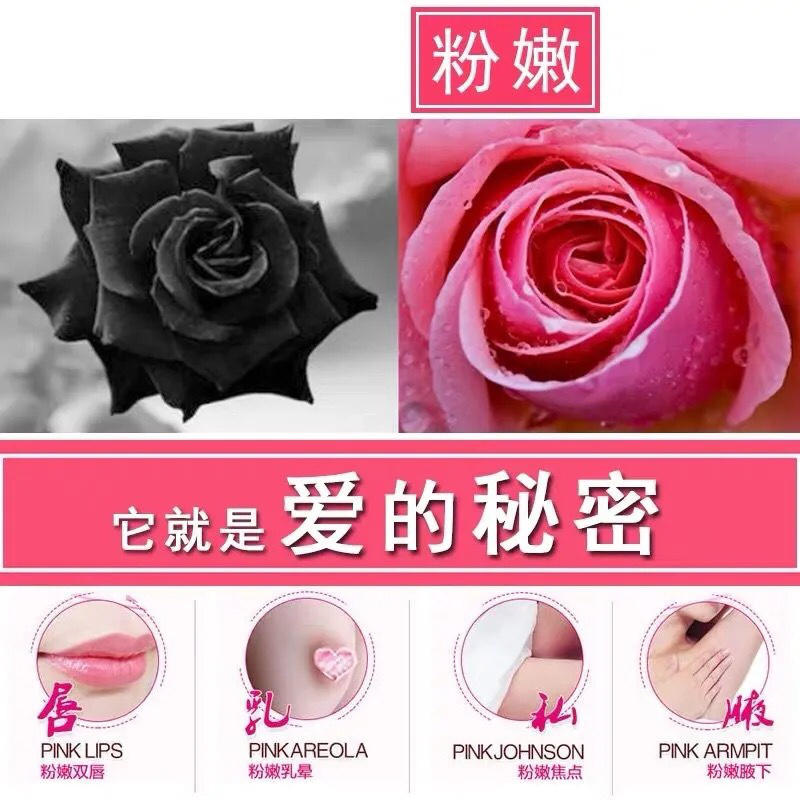

In [551]:
Image.open(train_data[i][4])

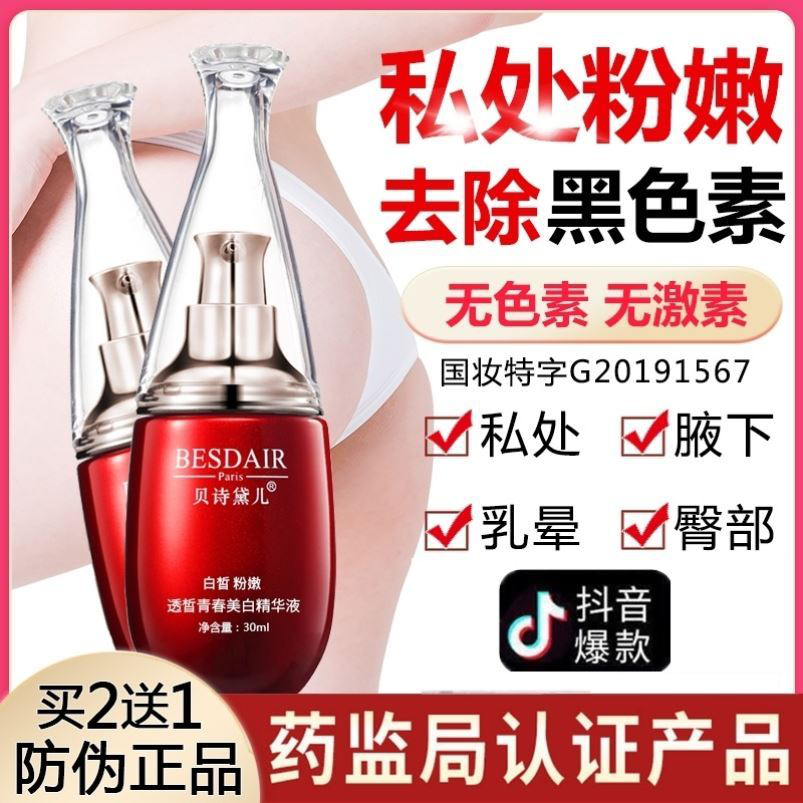

In [552]:
Image.open(train_data[i][8])

In [31]:
f = os.path.join(root_dir, "output", "ensemble", "deepAI_result_threshold=0.0.jsonl")
# f = os.path.join(root_dir, "output", "eca_nfnet_l0-v6-full", "deepAI_result_threshold=0.5.jsonl")
# f = os.path.join(root_dir, "output", "vit_base_patch16_384-v6-full", "deepAI_result_threshold=0.4.jsonl")
pred_dict = dict()
with open(f, "r", encoding="utf-8") as r:
    while True:
        line = r.readline()
        if not line:
            break
        d = json.loads(line.strip("\n"))
        key = d['src_item_id'] + "-" + d['tgt_item_id']
        pred_dict[key] = eval(d['tgt_item_emb'])[0]

In [33]:
valid_data = []
with open(os.path.join(root_dir, "processed", "finetune_valid.tsv"), "r", encoding="utf-8") as r:
    while True:
        line = r.readline()
        if not line:
            break
        item_label, src_item_id, src_title, src_pvs, tgt_item_id, tgt_title, tgt_pvs = line.strip("\n").split("\t")
        key = src_item_id + "-" + tgt_item_id
        if src_item_id not in id2image_name or tgt_item_id not in id2image_name:
            continue
#         if key not in pd2:
#             continue
        src_image_path = os.path.join(root_dir, "raw", "item_images", id2image_name[src_item_id]['item_image_name'])
        tgt_image_path = os.path.join(root_dir, "raw", "item_images", id2image_name[tgt_item_id]['item_image_name'])
        key = src_item_id + '-' + tgt_item_id
        pred = pred_dict[key]
        valid_data.append((pred, src_item_id, src_title, src_pvs, src_image_path, tgt_item_id, tgt_title, tgt_pvs, tgt_image_path))
print(len(valid_data))

20707


In [250]:
i = random.randint(0, len(valid_data))
print(f"label: {valid_data[i][0]}")
print(f"\nsrc title: {valid_data[i][2]}\ntgt title: {valid_data[i][6]}")

label: 0.015513791

src title: 原装 飞利浦 电动 剃须刀 刀头 刀网 HS190HQ190 特价 包邮 配件
tgt title: 飞利浦 电动 剃须刀 HQ8HQ8825HQ8885HQ8890HQ8894HQ8865 刀头 刀网


In [160]:
lines = []
key = valid_data[i][1] + "-" + valid_data[i][5]
items1 = valid_data[i][3].split(";")
items2 = valid_data[i][7].split(";")
j = 0
while j < len(items1) or j < len(items2):
    key1, val1 = "", ""
    if j < len(items1):
        key1, val1 = items1[j].split(":", maxsplit=1)
    key2, val2 = "", ""
    if j < len(items2):
        key2, val2 = items2[j].split(":", maxsplit=1)
    j += 1
    lines.append(pd.Series({"src_key": key1, "src_val": val1, "tgt_key": key2, "tgt_val": val2}))
pd.concat(lines, axis=1).transpose()
# print(pd.concat(lines[:30], axis=1).transpose())
# print(pd.concat(lines[30:], axis=1).transpose())

src_key                                            src_val    tgt_key  \
0         硬盘容量                                           512g固态硬盘         厚度   
1         能效等级                                                  无       适用场景   
2         适用场景  学生,移动工作站,女性定位,30876.g18,高清游戏,家庭影音,家庭娱乐,尊贵旗舰,炒股...     笔记本cpu   
3           厚度                               15.0mm(含)-18.0mm(不含)         尺寸   
4         显卡类型                                       nvidia mx450       显存容量   
5           尺寸                                               14英寸       显卡类型   
6       笔记本cpu                                       amd r7 5800u       能效等级   
7         显存容量                                             共享系统内存       颜色分类   
8         颜色分类                            t0cd i5-1135g7/8g/集显高色域       内存容量   
9         内存容量                                                8gb       硬盘容量   
10       屏幕刷新率                                               60hz      屏幕刷新率   
11     笔记本电脑类型                                                轻薄本    笔记本电脑类型   
12          品牌                                           thinkpad         品牌   
13       屏幕分辨率                                        1920x1080像素      屏幕分辨率   
14        售后服务                                               全国联保       售后服务   
15          型号                                                 14         型号   
16         保修期                                                 1年        保修期   
17        操作系统                                         windows 10       操作系统   
18        固态硬盘                                              512gb       固态硬盘   
19       是否超极本                                                  是      是否超极本   
20        屏幕比例                                               16:9       屏幕比例   
21        光驱类型                                                无光驱       光驱类型   
22       是否触摸屏                                                  否      是否触摸屏   
23        版本类型                                               中国大陆       版本类型   
24        屏幕类型                                         fhd ips显示屏       输入设备   
25        输入设备                                   触摸板,指纹识别,全尺寸背光键盘       屏幕类型   
26   是否pc平板二合一                                                  否  是否pc平板二合一   
27          重量                                   1.5kg(含)-2kg(不含)         重量   
28      通信技术类型                                       有线网卡,无线网卡,蓝牙     通信技术类型   
29     锂电池电芯数量                                             锂聚合物电池    锂电池电芯数量   
30       能效备案号                                                  无      能效备案号   
31          色域                                          srgb≥100%         色域   
32        上市时间                                         2019-07-03       上市时间   
33        屏幕边框                                 4.0mm(含)-7.0mm(不含)       屏幕边框   
34        套餐类型                                               官方标配         系列   
35   机身重量（含电池）                                              1.5kg         毛重   
36  thinkpad系列                                          thinkbook       包装尺寸   

                                              tgt_val  
0                                           20.0mm及以上  
1   炒股理财,学生,移动工作站,女性定位,30876.g18,高清游戏,家庭影音,设计制图,家庭...  
2                                         amd r5 3600  
3                                                15英寸  
4                                                 1gb  
5                                  amd radeon r5 m230  
6                                                  二级  
7                            i5-7200  独显2g   14寸   黑色  
8                                                 4gb  
9                                           512gb固态硬盘  
10                                               60hz  
11                                                商务本  
12                                          lenovo/联想  
13                                        1920x1080像素  
14                                               店铺三包  
15                                       340c      i3  
16            

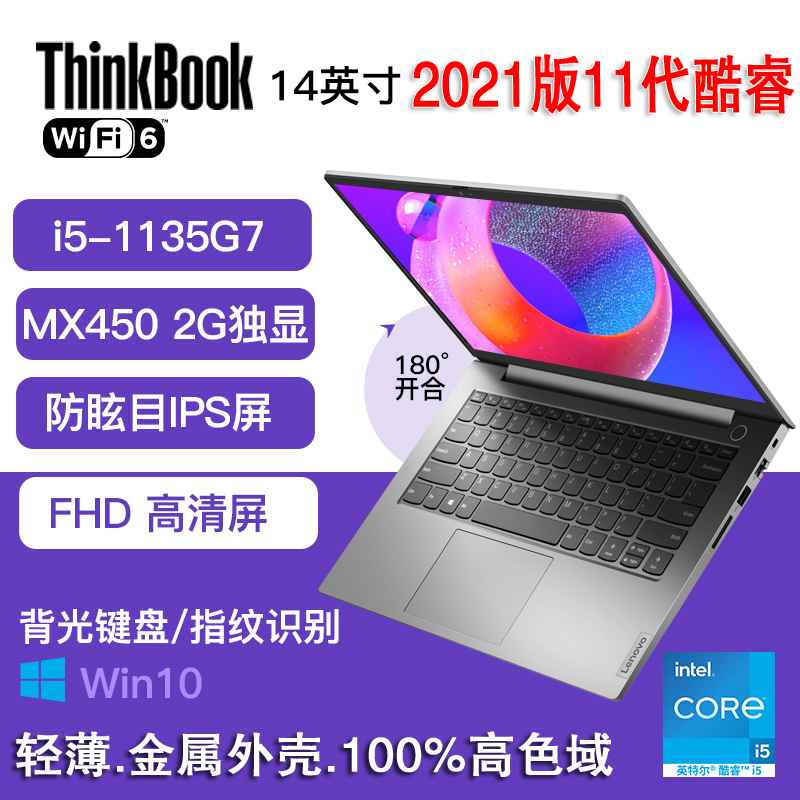

In [161]:
Image.open(valid_data[i][4])

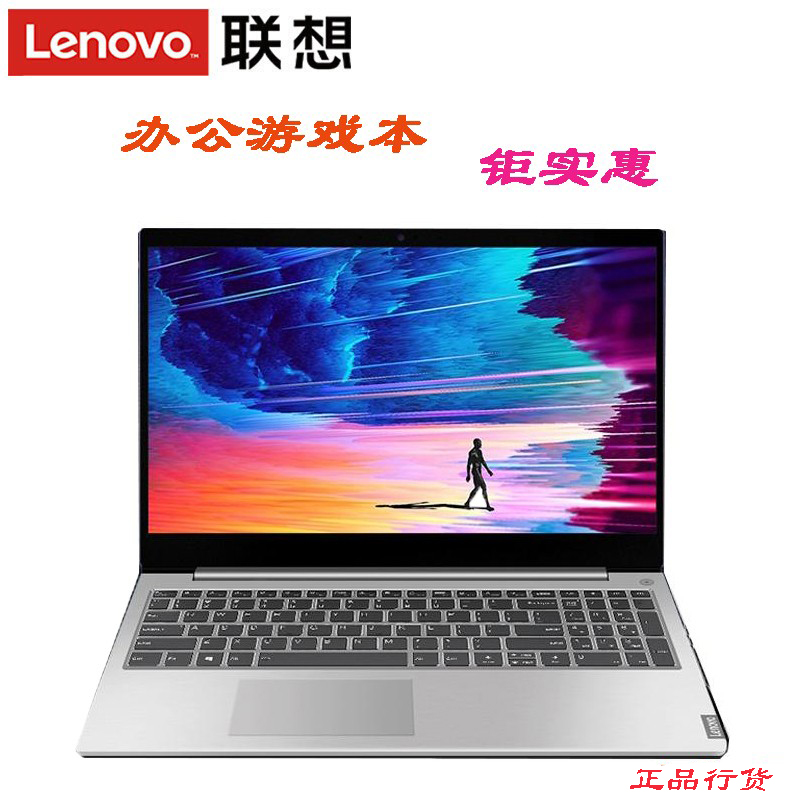

In [162]:
Image.open(valid_data[i][8])

In [4393]:
# pred_dict[key] = -pred_dict[key]
# pred_dict[key]

### 属性值标准化

In [4]:
import re
# 尺寸-标准化：休闲裤
SIZE_KEYS = ['尺寸', '规格', '裤尺寸', '尺码']
def size_norm(size): 
    p_2xs = re.compile("2xs|xxs|us0")
    p_xs = re.compile("xs|ss")
    p_s = re.compile("s|小码|小号")
    p_m = re.compile("(^m)|[^c]m|3码")
    p_l = re.compile("l|大码|4码")
    p_xl = re.compile("xl")
    p_2xl = re.compile("2xl|xxl|2尺3")
    p_3xl = re.compile("3xl|xxxl")
    p_4xl = re.compile("4xl|xxxxl|2尺5")
    p_5xl = re.compile("5xl|xxxxxl|2尺6")
    p_6xl = re.compile("6xl|xxxxxxl")
    p_7xl = re.compile("7xl|xxxxxxxl")
    p_8xl = re.compile("8xl|xxxxxxxxl")
    p_9xl = re.compile("9xl|xxxxxxxxxl")
    p_avg = re.compile("free|23/30|均码")

    pp_2xs = re.compile("24")
    pp_xs = re.compile("25|150")
    pp_s = re.compile("155|26")
    pp_m = re.compile("160|159|27")
    pp_l = re.compile("165|28|82")
    pp_xl = re.compile("29")
    pp_2xl = re.compile("30")
    pp_3xl = re.compile("31")
    pp_4xl = re.compile("84|32|106")
    pp_5xl = re.compile("86|33")
    pp_6xl = re.compile("34")
    pp_7xl = re.compile("35")
    pp_8xl = re.compile("36")
    pp_9xl = re.compile("38|39|40|41|42|44")
    
    v2s = {"1": "xs", "2": "xs", "26": "s", "55": "3xs", "66": "m", "70b": "l", "16": "xl"}
    
    # 预处理
    size = size.lower()
    
    new_size = ""
    # 值替换和处理
    if p_2xs.search(size) is not None:
        new_size = "2xs"
    elif p_xs.search(size) is not None:
        new_size = "xs"
    elif p_9xl.search(size) is not None:
        new_size = "9xl"
    elif p_8xl.search(size) is not None:
        new_size = "8xl"
    elif p_7xl.search(size) is not None:
        new_size = "7xl"
    elif p_6xl.search(size) is not None:
        new_size = "6xl"
    elif p_5xl.search(size) is not None:
        new_size = "5xl"
    elif p_4xl.search(size) is not None:
        new_size = "4xl"
    elif p_3xl.search(size) is not None:
        new_size = "3xl"
    elif p_2xl.search(size) is not None:
        new_size = "2xl"
    elif p_xl.search(size) is not None:
        new_size = "xl"
    elif p_l.search(size) is not None:
        new_size = "l"
    elif p_m.search(size) is not None:
        new_size = "m"
    elif p_s.search(size) is not None:
        new_size = "s"
    elif p_avg.search(size) is not None:
        new_size = "均码"
    else:
#         if pp_2xs.search(size) is not None:
#             new_size = "2xs"
#         elif pp_xs.search(size) is not None:
#             new_size = "xs"
#         elif pp_9xl.search(size) is not None:
#             new_size = "9xl"
#         elif pp_8xl.search(size) is not None:
#             new_size = "8xl"
#         elif pp_7xl.search(size) is not None:
#             new_size = "7xl"
#         elif pp_6xl.search(size) is not None:
#             new_size = "6xl"
#         elif pp_5xl.search(size) is not None:
#             new_size = "5xl"
#         elif pp_4xl.search(size) is not None:
#             new_size = "4xl"
#         elif pp_3xl.search(size) is not None:
#             new_size = "3xl"
#         elif pp_2xl.search(size) is not None:
#             new_size = "2xl"
#         elif pp_xl.search(size) is not None:
#             new_size = "xl"
#         elif pp_l.search(size) is not None:
#             new_size = "l"
#         elif pp_m.search(size) is not None:
#             new_size = "m"
#         elif pp_s.search(size) is not None:
#             new_size = "s"
#         elif size in v2s:
#             new_size = v2s[size]
#         else:
        new_size = size
    
    return new_size
    

In [675]:
# 颜色标准化：休闲裤
COLOR_KEYS = ['颜色分类']
def color_norm(color):
    p_color = re.compile("[^本颜纯片]色")
    p_color2 = re.compile("白|黑|绿|红|杏|褐|蓝|灰|粉|卡其|紫|黄|青")
    p_color3 = re.compile("卡|咖|条纹|格|迷彩")
    v2s = {'水墨':"黑色","浅卡":"卡其色","海军":"蓝色","深卡":"卡其色","香草米":"白色","格纹":"条纹色"}
    c2c = {'咖色':'咖啡色', "啡色":"咖啡色", "咖":"咖啡色", "其色":"卡其色", "仔色":"牛仔色", "糖色": "焦糖色", "格":"条纹",
           "咖":"咖啡色", "卡":"卡其色"}
    # 预处理
    color = color.lower().replace(" ", "")
    # 值处理
    res = p_color.search(color)
    res2 = p_color2.search(color)
    res3 = p_color3.search(color)
    if res is not None:
        new_color = res.group()
        typ = color.replace(new_color, "")
    elif res2 is not None:
        new_color = res2.group()
        typ = color.replace(new_color, "")
        new_color += "色"
    elif res3 is not None:
        new_color = res3.group()
        typ = color.replace(new_color, "")
    elif color in v2s:
        new_color = v2s[color]
        typ = color.replace(color, "")
    else:
        new_color = ""
        typ = color
    new_color = c2c.get(new_color, new_color)
    
    return new_color, typ

In [9]:
import copy
lines = []
for item_id, d in id_dict.items():
    dd = copy.deepcopy(d)
    ind = dd['industry_name']
    cate = dd['cate_name']
    pv_list = [("item_pvs", dd.get('item_pvs', '').split("#;#")), 
               ("sku_pvs", dd.get('sku_pvs', '').split("#;#"))]
    for kk, pvs in pv_list:
        item_pvs = []
        for pv in pvs:
            if len(pv) <= 0:
                continue
            key, val = pv.split("#:#", maxsplit=1)
            key = key.strip().lower()
            val = val.strip().lower()
            # 尺寸/尺码标准化
            if ind == '大服饰' and ("尺寸" in key or "尺码" in key):
                val = size_norm(val)
            item_pvs.append("#:#".join((key, val)))
        if len(item_pvs) > 0:
            dd[kk] = "#;#".join(item_pvs)
            
    lines.append(dd)
print(len(lines))

83085


In [10]:
version = "v1"
with open(os.path.join(root_dir, "raw", f"item_info_{version}.jsonl"), "w", encoding="utf-8") as w:
    for line in lines:
        w.write(json.dumps(line, ensure_ascii=False)+"\n")


#### 图像转换及cv模型的inspection

In [228]:
import timm
from timm.data.transforms_factory import create_transform
from torchvision.transforms import ToPILImage

In [226]:
f = "/Users/zeyesun/Documents/Data/cv/imagenet_1000_classes.txt"
imagenet_dict = dict()
with open(f, "r", encoding="utf-8") as r:
    ct = 0 
    while True:
        line = r.readline()
        if not line:
            break
        if ct == 0:
            ct += 1
            continue
        idx, name = line.strip("\n").split("\t")
        imagenet_dict[int(idx)] = name
print(len(imagenet_dict))

1000


In [229]:
model_name = "vit_base_patch16_384"
vit = timm.create_model(model_name, pretrained=True)

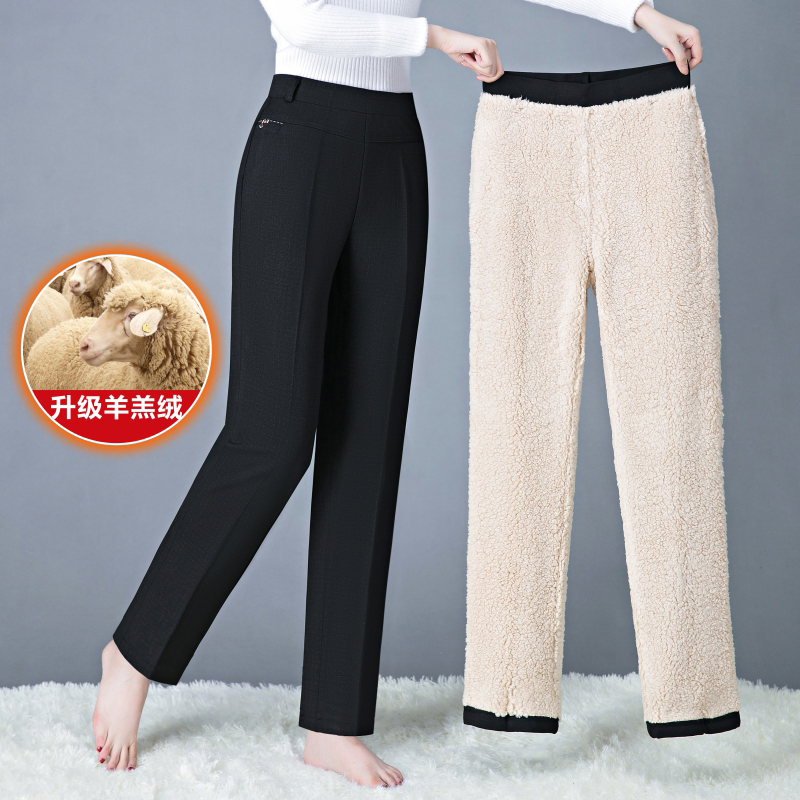

In [222]:
is_training = False
# is_training = True
hflip = 0.5
color_jitter = None
transform = create_transform(input_size=384, is_training=is_training,
                 hflip=hflip, color_jitter=color_jitter)
restore = ToPILImage()
# src_img = Image.open(train_data[i][4])
src_img = Image.open(valid_data[i][4])
src_img

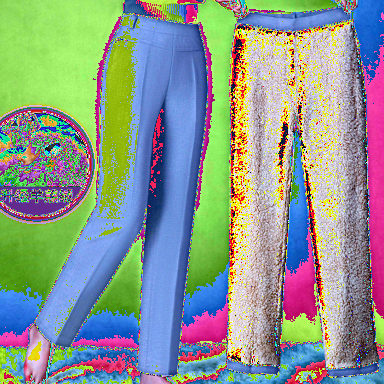

In [223]:
img = src_img.convert("RGB")
img = transform(img)
restore(img)

In [230]:
y = vit(img.unsqueeze(0))

In [231]:
k = 5
vals, indices = torch.topk(y, k=k, dim=-1)
vals = vals.tolist()[0]
indices = indices.tolist()[0]
for val, idx in zip(vals, indices):
    print(f"{imagenet_dict[idx]}: {val}")

jean, blue jean, denim: 9.562265396118164
suit, suit of clothes: 8.4008150100708
pajama, pyjama, pj's, jammies: 8.114726066589355
kimono: 6.937001705169678
sarong: 6.329758644104004


### 1. 抽取少量数据测试代码功能

In [ ]:
root_dir = "/Users/zeyesun/Documents/Data/ccks2022/task9_商品同款/raw"
# dtype = "train"
dtype = "valid"

In [ ]:
file_info = os.path.join(root_dir, f"item_{dtype}_info.jsonl")
file_pair = os.path.join(root_dir, f"item_{dtype}_pair.jsonl")
file_info_small = os.path.join(root_dir, f"item_{dtype}_info_small.jsonl")
file_pair_small = os.path.join(root_dir, f"item_{dtype}_pair_small.jsonl")

In [ ]:
import glob 
image_dir = os.path.join(root_dir, f"item_{dtype}_images")
image_paths = glob.glob(os.path.join(image_dir, "*")) 
image_names = set([img.split("/")[-1] for img in image_paths])
print(f"# total images: {len(image_paths)}, # unqiue images: {len(image_names)}")

In [ ]:
id2img = dict()
line_ct = 0
ct = 0
with open(file_info, "r", encoding="utf-8") as r:
    while True:
        line = r.readline()
        if not line:
            break
        d = json.loads(line.strip())
        item_id = d['item_id']
        item_image_name = d['item_image_name']
        if item_image_name in image_names:
            ct += 1
            id2img[item_id] = item_image_name
        line_ct += 1
print(f"total: {line_ct}, train: {ct}")

In [ ]:
item_id_pairs = set()
line_ct = 0
ct = 0
with open(file_pair, "r", encoding="utf-8") as r:
    while True:
        line = r.readline()
        if not line:
            break
        d = json.loads(line.strip())
        src_item_id = d['src_item_id']
        tgt_item_id = d['tgt_item_id']
        if src_item_id in id2img and tgt_item_id in id2img:
            item_id_pairs.add((src_item_id, tgt_item_id))
            ct += 1
        line_ct += 1
print(f"total pairs: {line_ct}, train pairs: {ct}")

In [ ]:
n = 250
item_id_pairs_small = random.sample(item_id_pairs, n)
item_ids_small = set()
for sid, tid in item_id_pairs_small:
    item_ids_small.add(sid)
    item_ids_small.add(tid)
print(len(item_ids_small))

In [ ]:
image_small_dir = os.path.join(root_dir, f"item_{dtype}_images_small")
if not os.path.exists(image_small_dir):
    os.mkdir(image_small_dir)
for item_id in item_ids_small:
    img_name = id2img[item_id]
    img_new = os.path.join(image_small_dir, img_name)
    img = os.path.join(image_dir, img_name)
    os.system(f"cp {img} {img_new}")
#     break

In [ ]:
# ct = 0
# line_ct = 0
with open(file_info_small, "w", encoding="utf-8") as w:
    with open(file_info, "r", encoding="utf-8") as r:
        while True:
            line = r.readline()
            if not line:
                break
            d = json.loads(line.strip())
#             item_image_name = d['item_image_name']
            item_id = d['item_id']
            if item_id in item_ids_small:
#                 train_images_name.add(item_image_name)
#                 train_item_ids.add(item_id)
                w.write(line)
#                 ct += 1
#             line_ct += 1
# print(f"# distince item ids: {len(train_item_ids)}")

In [ ]:
# ct = 0
# line_ct = 0
with open(file_pair_small, "w", encoding="utf-8") as w:
    with open(file_pair, "r", encoding="utf-8") as r:
        while True:
            line = r.readline()
            if not line:
                break
            d = json.loads(line.strip())
            src_item_id = d['src_item_id']
            tgt_item_id = d['tgt_item_id']
            if src_item_id in item_ids_small and tgt_item_id in item_ids_small:
                w.write(line)
#                 ct += 1
#             line_ct += 1
# print(f"total: {line_ct}, small: {ct}")

### 2. 构建OpenKE (TransE)的训练数据

In [ ]:
root_dir = "/Users/zeyesun/Documents/Data/ccks2022/task9_商品同款/raw"
dtypes = ["train", "valid"]

In [ ]:
relation_count = dict()
relation_one2n = dict()
for dtype in dtypes:
    file_info = os.path.join(root_dir, f"item_{dtype}_info.jsonl") 
    with open(file_info, "r", encoding="utf-8") as r:
        while True:
            line = r.readline()
            if not line:
                break
            d = json.loads(line.strip())
            cate_name = d['cate_name']
            
            # item pvs
            if 'item_pvs' in d:
                if cate_name not in relation_count:
                    relation_count[cate_name] = dict()
                    relation_one2n[cate_name] = dict()
                rels = dict()
                for item_pv in d['item_pvs'].replace("#", "").split(";"):
                    try:
                        relation_key, v = item_pv.split(":", maxsplit=1)
                    except Exception:
                        print(f"[Item Pv Split Error] {item_pv}")
                        continue
                    if relation_key not in relation_count[cate_name]:
                        relation_count[cate_name][relation_key] = 0
                    if relation_key not in rels:
                        rels[relation_key] = [v]
                    else:
                        if relation_key not in relation_one2n[cate_name]:
                            relation_one2n[cate_name][relation_key] = set(rels[relation_key])
                        relation_one2n[cate_name][relation_key].add(v)
                    relation_count[cate_name][relation_key] += 1
print(f"# cates: {len(relation_count)}")

In [ ]:
# f = os.path.join(root_dir, "relation_one2n.txt")
# with open(f, "w", encoding="utf-8") as w:
#     for cate, val in relation_one2n.items():
#         for k, v in val.items():
#             w.write("\t".join((cate, k, "||".join(v))) + "\n")

In [ ]:
# relation_count = dict()
# for dtype in dtypes:
#     file_info = os.path.join(root_dir, f"item_{dtype}_info.jsonl") 
#     with open(file_info, "r", encoding="utf-8") as r:
#         while True:
#             line = r.readline()
#             if not line:
#                 break
#             d = json.loads(line.strip())
#             cate_name = d['cate_name']
            
#             # item pvs
#             if 'item_pvs' in d:
#                 if cate_name not in relation_count:
#                     relation_count[cate_name] = dict()
#                 for item_pv in d['item_pvs'].replace("#", "").split(";"):
#                     try:
#                         relation_key, v = item_pv.split(":", maxsplit=1)
#                     except Exception:
#                         print(f"[Item Pv Split Error] {item_pv}")
#                         continue
#                     if relation_key not in relation_count[cate_name]:
#                         relation_count[cate_name][relation_key] = 0
#                     relation_count[cate_name][relation_key] += 1
# print(f"# cates: {len(relation_count)}")

In [ ]:
cate_cts = []
for cate, val_dict in relation_count.items():
    cate_cts.append(len(val_dict))
percentiles = np.arange(10,110,10)
np.percentile(cate_cts, percentiles)

In [ ]:
# NUM_RELATIONS_PER_CATE = 20
MIN_COUNT_RELATION = 10 # 如果某个品类中，该relation出现次数不足，则剔除该relation
relation_include = set()
for cate, val_dict in relation_count.items():
    # 方法1：根据最小出现次数筛选
    for relation, ct in val_dict.items():
        if ct >= MIN_COUNT_RELATION:
            relation_include.add(relation)
#     # 方法2：根据出现次数top-n筛选
#     sorted_val_dict = {k: v for k, v in sorted(val_dict.items(), key=lambda item: item[1], reverse=True)}
#     for i, (cate, ct) in enumerate(sorted_val_dict.items()):
#         if i >= NUM_RELATIONS_PER_CATE:
#             break
#         relation_include.add(cate)
relation_include.add(RELATION_CATE_NAME)
relation_include.add(RELATION_INDUSTRY_NAME)
print(f"# relations: {len(relation_include)}")

In [ ]:
# triplet
triplets = set()
# entity dict
# UNKNOW_ITEM = "/item/unknown"
# UNKNOW_VALUE = "/value/unknown"
# UNKNOW_ITEM_ID = 0
# UNKNOW_VALUE_ID = 1
entity_dict = dict()
# entity_dict[UNKNOW_ITEM] = UNKNOW_ITEM_ID
# entity_dict[UNKNOW_VALUE] = UNKNOW_VALUE_ID
# relation dict
RELATION_CATE_NAME = "cate_name"
RELATION_CATE_NAME_ID = 0
RELATION_INDUSTRY_NAME = "industry_name"
RELATION_INDUSTRY_NAME_ID = 1
relation_dict = dict()
relation_dict[RELATION_CATE_NAME] = RELATION_CATE_NAME_ID
relation_dict[RELATION_INDUSTRY_NAME] = RELATION_INDUSTRY_NAME_ID

In [ ]:
# entity_id = UNKNOW_VALUE_ID
entity_id = -1
relation_id = RELATION_INDUSTRY_NAME_ID
for dtype in dtypes:
    file_info = os.path.join(root_dir, f"item_{dtype}_info.jsonl") 
    with open(file_info, "r", encoding="utf-8") as r:
        while True:
            line = r.readline()
            if not line:
                break
            d = json.loads(line.strip())
            item_id = d['item_id']
            head_entity_key = f"/item/{item_id}"
            if head_entity_key not in entity_dict:
                entity_id += 1
                entity_dict[head_entity_key] = entity_id
            
            # triplet - cate_name
            cate_name = d['cate_name']
            cate_id = d['cate_id']
            tail_entity_key = f"/value/{cate_name}-{cate_id}"
            if tail_entity_key not in entity_dict:
                entity_id += 1
                entity_dict[tail_entity_key] = entity_id
            triplet = tuple((entity_dict[head_entity_key], RELATION_CATE_NAME_ID, entity_dict[tail_entity_key]))
            triplets.add(triplet)
            
            # triplet - industry_name
            industry_name = d['industry_name']
            tail_entity_key = f"/value/{industry_name}"
            if tail_entity_key not in entity_dict:
                entity_id += 1
                entity_dict[tail_entity_key] = entity_id
            triplet = tuple((entity_dict[head_entity_key], RELATION_INDUSTRY_NAME_ID, entity_dict[tail_entity_key]))
            triplets.add(triplet)
            
            # item pvs
            if 'item_pvs' in d:
                if cate_name not in relation_count:
                    relation_count[cate_name] = dict()
                for item_pv in d['item_pvs'].replace("#", "").split(";"):
                    try:
                        relation_key, v = item_pv.split(":", maxsplit=1)
                    except Exception:
                        print(f"[Item Pv Split Error] {item_pv}")
                        continue
                    if relation_key not in relation_include:
                        continue
                    tail_entity_key = f"/value/{v}"
                    if tail_entity_key not in entity_dict:
                        entity_id += 1
                        entity_dict[tail_entity_key] = entity_id
                    if relation_key not in relation_dict:
                        relation_id += 1
                        relation_dict[relation_key] = relation_id
                    triplet = tuple((entity_dict[head_entity_key], relation_dict[relation_key], entity_dict[tail_entity_key]))
                    triplets.add(triplet)
print(f"# triplets: {len(triplets)}, # relations: {len(relation_dict)}, # entities: {len(entity_dict)}")

In [ ]:
output_dir = "/Users/zeyesun/Documents/Data/ccks2022/task9_商品同款/processed"
file_train2id = os.path.join(output_dir, "train2id.txt")
file_test2id = os.path.join(output_dir, "test2id.txt")
file_entity2id = os.path.join(output_dir, "entity2id.txt")
file_relation2id = os.path.join(output_dir, "relation2id.txt")

In [ ]:
with open(file_entity2id, "w", encoding="utf-8") as w:
    w.write(str(len(entity_dict))+"\n")
    for entity_name, entity_id in entity_dict.items():
        w.write("\t".join((entity_name, str(entity_id)))+"\n")

In [ ]:
with open(file_relation2id, "w", encoding="utf-8") as w:
    w.write(str(len(relation_dict))+"\n")
    for relation_name, relation_id in relation_dict.items():
        w.write("\t".join((relation_name, str(relation_id)))+"\n")

In [ ]:
import random
triplets = list(triplets)
random.shuffle(triplets)
proportion = 0.1
split_index = int(len(triplets)*proportion)
triplets_train = triplets[split_index:]
triplets_test = triplets[:split_index]
print(f"# train: {len(triplets_train)}, # test: {len(triplets_test)}")

In [ ]:
with open(file_train2id, "w", encoding="utf-8") as w:
    w.write(str(len(triplets_train))+"\n")
    for hid, rid, tid in triplets_train:
        w.write("\t".join((str(hid), str(rid), str(tid)))+"\n")

In [ ]:
with open(file_test2id, "w", encoding="utf-8") as w:
    w.write(str(len(triplets_test))+"\n")
    for hid, rid, tid in triplets_test:
        w.write("\t".join((str(hid), str(rid), str(tid)))+"\n")

#### 筛选relation

In [ ]:
root_dir = "/Users/zeyesun/Documents/Data/ccks2022/task9_商品同款/raw"
dtype = "train"
# dtype = "valid"
file_info = os.path.join(root_dir, f"item_{dtype}_info.jsonl")
file_pair = os.path.join(root_dir, f"item_{dtype}_pair.jsonl")

In [ ]:
id_dict = dict()
# tf = dict()
# idf = dict()
with open(file_info, "r", encoding="utf-8") as r:
    while True:
        line = r.readline()
        if not line:
            break
        d = json.loads(line.strip())
        item_id = d['item_id']
        item_pvs = d.get("item_pvs", "").replace("#", "")
        for pv in item_pvs.split(";"):
            try:
                rel, t = pv.split(":", maxsplit=1)
            except ValueError:
                continue
#             if rel not in tf:
#                 tf[rel] = 0
#             tf[rel] += 1
        id_dict[item_id] = d
print(f"{len(id_dict)}")

In [ ]:
lines = []
rel_ct = dict()
with open(file_pair, "r", encoding="utf-8") as r:
    while True:
        line = r.readline()
        if not line:
            break
        d = json.loads(line.strip())
        src_item_id = d['src_item_id']
        tgt_item_id = d['tgt_item_id']
        item_label = d.get('item_label', "")
        d1 = id_dict[src_item_id]
        d2 = id_dict[tgt_item_id]
        cate_name = d1['cate_name']
        pv1 = dict()
        for pv in d1.get('item_pvs', "").replace("#", "").split(";"):
            try:
                rel, t = pv.split(":", maxsplit=1)
            except ValueError:
                continue
            if rel not in pv1:
                pv1[rel] = set()
            pv1[rel].add(t)
        pv2 = dict()
        for pv in d2.get('item_pvs', "").replace("#", "").split(";"):
            try:
                rel, t = pv.split(":", maxsplit=1)
            except ValueError:
                continue
            if rel not in pv2:
                pv2[rel] = set()
            pv2[rel].add(t)
        rels1 = set(pv1.keys())
        rels2 = set(pv2.keys())
        rels = rels1.intersection(rels2)
#         pvs1 = set(pv1)
#         pvs2 = set(pv2)
#         pvs_union = pvs1.union(pvs2)
#         pvs_intersect = pvs1.intersection(pvs2)
#         pvs_diff = pvs_union.difference(pvs_intersect)
        if cate_name not in rel_ct:
            rel_ct[cate_name] = dict()
        for rel in rels:
            if rel not in rel_ct[cate_name]:
                rel_ct[cate_name][rel] = {"1-total":0, "0-total":0, "1-same":0, "0-diff":0, "1-diff":0, "0-same":0}
            if item_label == "1":
                if pv1[rel] == pv2[rel]:
                    rel_ct[cate_name][rel]['1-same'] += 1
                else:
                    rel_ct[cate_name][rel]['1-diff'] += 1
                rel_ct[cate_name][rel]['1-total'] += 1
            elif item_label == "0":
                if pv1[rel] == pv2[rel]:
                    rel_ct[cate_name][rel]['0-same'] += 1
                else:
                    rel_ct[cate_name][rel]['0-diff'] += 1
                rel_ct[cate_name][rel]['0-total'] += 1

#         res = {'label': item_label,
#                "id1": src_item_id,
#                "title1": d1['title'],
#                "cate_name1": d1['cate_name'],
#                "industry_name1": d1['industry_name'],
#                "item_pvs1": pv1,
#                "id2": tgt_item_id,
#                "title2": d2['title'],
#                "cate_name2": d2['cate_name'],
#                "industry_name2": d2['industry_name'],
#                "item_pvs2": pv2}
#         lines.append(pd.Series(res))
# df = pd.concat(lines, axis=1).transpose()
# print(df.shape)

In [ ]:
threshold = 10
for cate, val in rel_ct.items():
    for rel, v in val.items():
        v['0-diff-rate'] = 0.0
        v['1-same-rate'] = 0.0
        if v['0-total'] + v['1-total'] >= threshold:
            v['0-diff-rate'] = v['0-diff'] / v['0-total'] if v['0-total'] > 0 else 0.0
            v['1-same-rate'] = v['1-same'] / v['1-total'] if v['1-total'] > 0 else 0.0
        

In [ ]:
for cate, val in rel_ct.items():
    print(f"cate name: {cate}")
#     print([k for k, v in sorted(val.items(), key=lambda item: item[1]['0-diff-rate']-item[1]['1-diff-rate'], reverse=True)])
    print({k:v for k, v in sorted(val.items(), key=lambda item: item[1]['0-diff-rate']+item[1]['1-same-rate'], reverse=True)})


In [ ]:
# rd = dict()
for rel, v in rel_ct.items():
    v['intersect_rate'] = v['intersect'] / v['total']
    v['diff_rate'] = v['diff'] / v['total']

In [ ]:
# keys = list(rel_ct.keys())
# i = 0
{k: v for k, v in sorted(rel_ct.items(), key=lambda item: item[1]['total'], reverse=True)}
# {k: v for k, v in sorted(rel_ct.items(), key=lambda item: item[1]['diff_rate'], reverse=True)}
# {k: v for k, v in sorted(rel_ct.items(), key=lambda item: item[1]['intersect_rate'], reverse=True)}

In [ ]:
f = os.path.join(root_dir, f"item_{dtype}_pair.xlsx")
df.to_excel(f, index=False)

### 3. 预测结果分析

In [ ]:
file_label = os.path.join(root_dir, "processed", "v3", "finetune_train_train.tsv")
file_pred = os.path.join(root_dir, "output", "roberta_base-one_tower-cls-ce", "deepAI_result_threshold=0.5.jsonl")

In [ ]:
lines = []
with open(file_label, "r", encoding="utf-8") as r1:
    with open(file_pred, "r", encoding="utf-8") as r2:
        while True:
            line1 = r1.readline()
            line2 = r2.readline()
            if not line1 or not line2:
                break
            items = line1.strip("\n").split("\t")
            d = json.loads(line2.strip())
            src_item_id = d['src_item_id']
            tgt_item_id = d['tgt_item_id']
            d1 = id_dict[src_item_id]
            pv1 = d1.get('item_pvs', "").replace("#", "")
            title1 = d1['title']
            d2 = id_dict[tgt_item_id]
            title2 = d2['title']
            pv2 = d2.get('item_pvs', "").replace("#", "")
            ps = pd.Series({"label": items[0],
                           "pred": "1" if eval(d['tgt_item_emb'])[0] >= d['threshold'] else "0",
                           "prob": eval(d['tgt_item_emb'])[0],
                            "image1": d1.get('item_image_name', ''),
                           "title1": title1,
                           "pv1_processed": items[3],
                           "pv1": pv1,
                            "image2": d2.get('item_image_name', ''),
                           "title2": title2,
                           "pv2_processed": items[6],
                           "pv2": pv2})
            lines.append(ps)
df = pd.concat(lines, axis=1).transpose()
df.shape

In [ ]:
file_output = os.path.join(root_dir, "output", "roberta_base-one_tower-cls-ce", "deepAI_result_threshold=0.4.xlsx")
df.to_excel(file_output, index=False)

In [ ]:
file_pred = os.path.join(root_dir, "processed", "finetune_valid.tsv")
# file_pred = os.path.join(root_dir, "output", "roberta_base-one_tower-cls-ce", "deepAI_result_threshold=0.5.jsonl")
# file_out = os.path.join(root_dir, "output", "roberta_base-one_tower-cls-ce", "deepAI_result_threshold=0.5_new.jsonl")
file_out = os.path.join(root_dir, "processed", "finetune_valid_same_cate.tsv")
# file_out = os.path.join(root_dir, "raw", "", "item_valid_pair-roberta_base-one_tower-cls-ce-threshold=0.5.jsonl")




In [ ]:
ct = 0
ct_error = 0
ct_1 = 0
lines = []
w = open(file_out, "w", encoding="utf-8")
with open(file_pred, "r", encoding="utf-8") as r:
    while True:
        line = r.readline()
        if not line:
            break
        items = line.strip("\n").split("\t")
        src_item_id = items[1]
        tgt_item_id = items[4]
#         d = json.loads(line.strip())
#         src_item_id = d['src_item_id']
#         tgt_item_id = d['tgt_item_id']
        d1 = id_dict[src_item_id]
        cate1 = d1['cate_name']
        ind1 = d1['industry_name']
        d2 = id_dict[tgt_item_id]
        cate2 = d2['cate_name']
        ind2 = d2['industry_name']
#         prob_1 = eval(d['tgt_item_emb'])[0]
#         prob_0 = eval(d['src_item_emb'])[0]
#         if prob_1 >= d['threshold']:
#             ct_1 += 1
#         if cate1 != cate2 and prob_1 >= d['threshold']:
# #             if ind1 != ind2 and prob >= d['threshold']:
#             d['tgt_item_emb'] = f"[{prob_0}]"
#             d['src_item_emb'] = f"[{prob_1}]"
#             ct_error += 1
#             lines.append((d, d1, d2))
        if cate1 == cate2:
#             item_label = "1" if prob_1 >= d['threshold'] else "0"
#             res = {"src_item_id": src_item_id, "tgt_item_id": tgt_item_id, "item_label": item_label}
#             w.write(json.dumps(res)+"\n")
            w.write(line)
        ct += 1
#         w.write(json.dumps(d)+"\n")
w.close()
print(f"ct: {ct}, ct_1: {ct_1}, ct_error: {ct_error}")
src_item_id = items[1]

In [ ]:
i = 678
lines[i]

In [ ]:
13/(0.8269/0.8532-0.8228/0.8528)
# t*0.8228

### 4. torchkge

In [ ]:
from torch import cuda
from torch.optim import Adam

from torchkge.models import TransEModel
from torchkge.sampling import BernoulliNegativeSampler
from torchkge.utils import MarginLoss, DataLoader
from torchkge.utils.datasets import load_fb15k

from tqdm.autonotebook import tqdm

In [ ]:
# Load dataset
kg_train, _, _ = load_fb15k()

In [ ]:
import shutil

from os import environ, makedirs
from os.path import exists, expanduser, join
def get_data_home(data_home=None):
    """Returns the path to the data directory. The path is created if
    it does not exist.

    If data_home is none, the data is downloaded into the home directory of
    of the user.

    Parameters
    ----------
    data_home: string
        The path to the data set.
    """
    if data_home is None:
        data_home = environ.get('TORCHKGE_DATA',
                                join('~', 'torchkge_data'))
    data_home = expanduser(data_home)
    if not exists(data_home):
        makedirs(data_home)
    return data_home

In [ ]:
data_home = get_data_home()

In [ ]:
data_home

In [ ]:
# Define some hyper-parameters for training
emb_dim = 100
lr = 0.0004
n_epochs = 1000
b_size = 32768
margin = 0.5

# Define the model and criterion
model = TransEModel(emb_dim, kg_train.n_ent, kg_train.n_rel, dissimilarity_type='L2')
criterion = MarginLoss(margin)

# Move everything to CUDA if available
if cuda.is_available():
    cuda.empty_cache()
    model.cuda()
    criterion.cuda()

# Define the torch optimizer to be used
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

sampler = BernoulliNegativeSampler(kg_train)
dataloader = DataLoader(kg_train, batch_size=b_size, use_cuda=None)

In [ ]:
iterator = tqdm(range(n_epochs), unit='epoch')
for epoch in iterator:
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        h, t, r = batch[0], batch[1], batch[2]
        n_h, n_t = sampler.corrupt_batch(h, t, r)

        optimizer.zero_grad()

        # forward + backward + optimize
        pos, neg = model(h, t, r, n_h, n_t)
        loss = criterion(pos, neg)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    iterator.set_description(
        'Epoch {} | mean loss: {:.5f}'.format(epoch + 1,
                                              running_loss / len(dataloader)))

model.normalize_parameters()

### 5. model ensemble

In [68]:
# only_valid_cates = ['投资贵金属', '客厅吸顶灯','衬衫','电热水壶','养生壶/煎药壶','鞋柜','脱毛膏','自热火锅','洗烘套装','椰棕床垫','足浴器','茶壶','电动自行车']
only_valid_cates = ['鞋柜', '洗衣机', '衬衫', '茶壶', '电动自行车', '脱毛膏', '投资贵金属', '椰棕床垫', '身体乳液', '客厅吸顶灯', '电热水壶', '足浴器', '养生壶/煎药壶', '洗烘套装', '自热火锅']

In [108]:
#出现过：(rl-v3.4-0.3, rlcat-v3.4-0.4, rl-v4-0.3, ril-v5-0.4, el0-v6-0.4, pl-v3.4-0.4, bb-0.3, tc-v3.4-0.6)
models_and_thresholds = [
#     ("roberta_base-v3.4-one_tower-cls-ce", 0.4), 
    ("roberta_large-v3.4-full-one_tower-cls-NA-ce", 0.3, 0.8610), 
#     ("roberta_large-v3.6-full-one_tower-cls-NA-ce", 0.4, 0.8478), 
    ("roberta_large-v3.4-one_tower-cls_1,2,3,4_cat-ce", 0.4, 0.8600),
    ("roberta_large-v4-full-one_tower-cls-NA-ce", 0.3, 0.8612),
    ("roberta_image_large-v5-full-one_tower-cls-begin-ce", 0.4, 0.8582),
#     ("roberta_image_large-v5.1-one_tower-cls-begin-ce", 0.4, 0.8446),
    ("eca_nfnet_l0-v6-full", 0.4, 0.7777),
    ("pkgm_large-v3.4-full-one_tower-cls-NA-ce", 0.4, 0.8096),
#     ("item_alignment-k3m_base", 0.6, 0.7635),
    ("bert_base-two_tower-cls-ce", 0.3, 0.8510),
#     ("bert_adversarial-two_tower-cls-ce", 0.3, 0.8477),
#     ("fasttext", 0.5, 0.7024),
    ("textcnn-v3.4-full-two_tower-cls-NA-ce", 0.6, 0.7703),
#     ("coca_base-v5.2-two_tower-cls-sum-ce", 0.5, 0.7875),
#     ("coca_large-v5.2-full-two_tower-cls-sum-ce", 0.5, 0.7784),
#     ("vit_base_patch16_384-v6.2-full", 0.5, 0.7685)
]
lines = dict()
res = dict()
ct_consistent = 0
ct_p = 0
ct_n = 0
for model, threshold, f1 in models_and_thresholds:
    f = os.path.join(root_dir, "output", model, f"deepAI_result_threshold=0.4.jsonl")
    ct = 0
    total = 0
    with open(f, "r", encoding="utf-8") as r:
        while True:
            line = r.readline()
            if not line:
                break
            d = json.loads(line.strip())
            src_item_id = d['src_item_id']
            src_cate_name = id_dict[src_item_id]['cate_name']
            tgt_item_id = d['tgt_item_id']
            tgt_cate_name = id_dict[tgt_item_id]['cate_name']
            if src_cate_name in only_valid_cates or tgt_cate_name in only_valid_cates:
                continue
            key = src_item_id + "-" + tgt_item_id
            prob = eval(d['tgt_item_emb'])[0]
#             thresh = d['threshold']
            if key not in lines:
                dd = copy.deepcopy(d)
                dd['tgt_item_emb'] = prob - threshold
                dd['0'] = 0.0
                dd['1'] = 0.0
                lines[key] = dd
            else:
                lines[key]['tgt_item_emb'] += prob - threshold
            if prob >= threshold:
                ct += 1
                lines[key]['1'] += f1
            else:
                lines[key]['0'] += f1
            total += 1
    print(f"{model}-{threshold} p: {ct}, total: {total}")
# print(f"consistent: {ct_consistent}, both p: {ct_p}, both n: {ct_n}, total: {total}")

roberta_large-v3.4-full-one_tower-cls-NA-ce-0.3 p: 4130, total: 11459
roberta_large-v3.4-one_tower-cls_1,2,3,4_cat-ce-0.4 p: 4169, total: 11459
roberta_large-v4-full-one_tower-cls-NA-ce-0.3 p: 4198, total: 11459
roberta_image_large-v5-full-one_tower-cls-begin-ce-0.4 p: 4250, total: 11459
eca_nfnet_l0-v6-full-0.4 p: 6490, total: 11459
pkgm_large-v3.4-full-one_tower-cls-NA-ce-0.4 p: 4426, total: 11459
bert_base-two_tower-cls-ce-0.3 p: 4209, total: 11459
textcnn-v3.4-full-two_tower-cls-NA-ce-0.6 p: 4682, total: 11459


In [109]:
# 未出现过：(rl-v3.4-0.4, rlcat-v3.4-0.4, rl-v4-0.5, ril-v5-0.4, pl-v3.4-0.5, bb-0.4, tc-v3.4-0.6)
models_and_thresholds = [
#     ("roberta_base-v3.4-one_tower-cls-ce", 0.4), 
    ("roberta_large-v3.4-full-one_tower-cls-NA-ce", 0.4, 0.8610), 
#     ("roberta_large-v3.6-full-one_tower-cls-NA-ce", 0.4, 0.8583), 
    ("roberta_large-v3.4-one_tower-cls_1,2,3,4_cat-ce", 0.4, 0.8600),
    ("roberta_large-v4-full-one_tower-cls-NA-ce", 0.5, 0.8612),
    ("roberta_image_large-v5-full-one_tower-cls-begin-ce", 0.4, 0.8582),
#     ("roberta_image_large-v5.1-one_tower-cls-begin-ce", 0.4, 0.8446),
#     ("eca_nfnet_l0-v6-full", 0.5, 0.7783),
    ("pkgm_large-v3.4-full-one_tower-cls-NA-ce", 0.5, 0.8096),
#     ("item_alignment-k3m_base", 0.6, 0.7635),
    ("bert_base-two_tower-cls-ce", 0.4, 0.8510),
#     ("bert_adversarial-two_tower-cls-ce", 0.3, 0.8477),
#     ("fasttext", 0.5, 0.7024),
    ("textcnn-v3.4-full-two_tower-cls-NA-ce", 0.6, 0.7703),
#     ("coca_base-v5.2-two_tower-cls-sum-ce", 0.5, 0.7875),
#     ("coca_large-v5.2-full-two_tower-cls-sum-ce", 0.5, 0.7882),
#     ("vit_base_patch16_384-v6.2-full", 0.5, 0.7685)
]
# lines = dict()
ct_consistent = 0
ct_p = 0
ct_n = 0
for model, threshold, f1 in models_and_thresholds:
    f = os.path.join(root_dir, "output", model, f"deepAI_result_threshold=0.4.jsonl")
    ct = 0
    total = 0
    with open(f, "r", encoding="utf-8") as r:
        while True:
            line = r.readline()
            if not line:
                break
            d = json.loads(line.strip())
            src_item_id = d['src_item_id']
            src_cate_name = id_dict[src_item_id]['cate_name']
            tgt_item_id = d['tgt_item_id']
            tgt_cate_name = id_dict[tgt_item_id]['cate_name']
            if src_cate_name in only_valid_cates or tgt_cate_name in only_valid_cates:
                key = src_item_id + "-" + tgt_item_id
                prob = eval(d['tgt_item_emb'])[0]
    #             thresh = d['threshold']
                if key not in lines:
                    dd = copy.deepcopy(d)
                    dd['tgt_item_emb'] = prob - threshold
                    dd['0'] = 0.0
                    dd['1'] = 0.0
                    lines[key] = dd
                else:
                    lines[key]['tgt_item_emb'] += prob - threshold
                if prob >= threshold:
                    ct += 1
                    lines[key]['1'] += f1
                else:
                    lines[key]['0'] += f1
                total += 1
    print(f"{model}-{threshold} p: {ct}, total: {total}")
# print(f"consistent: {ct_consistent}, both p: {ct_p}, both n: {ct_n}, total: {total}")

roberta_large-v3.4-full-one_tower-cls-NA-ce-0.4 p: 847, total: 4450
roberta_large-v3.4-one_tower-cls_1,2,3,4_cat-ce-0.4 p: 948, total: 4450
roberta_large-v4-full-one_tower-cls-NA-ce-0.5 p: 929, total: 4450
roberta_image_large-v5-full-one_tower-cls-begin-ce-0.4 p: 1006, total: 4450
pkgm_large-v3.4-full-one_tower-cls-NA-ce-0.5 p: 1055, total: 4450
bert_base-two_tower-cls-ce-0.4 p: 997, total: 4450
textcnn-v3.4-full-two_tower-cls-NA-ce-0.6 p: 1258, total: 4450


In [23]:
# f = os.path.join(root_dir, "output", "vit_base_patch16_384-v6-full", "deepAI_result_threshold=0.5.jsonl")
f = os.path.join(root_dir, "output", "eca_nfnet_l0-v6-full", "deepAI_result_threshold=0.5.jsonl")
pred_dict = dict()
with open(f, "r", encoding="utf-8") as r:
    while True:
        line = r.readline()
        if not line:
            break
        d = json.loads(line.strip("\n"))
        key = d['src_item_id'] + "-" + d['tgt_item_id']
        pred_dict[key] = eval(d['tgt_item_emb'])[0]

In [53]:
post_processing = 0

In [110]:
lines_ensemble = []
lines_cv_included = []
threshold = 0.0
cv_threshold = 0.99
total = 0
ct = 0
cv_included_ct = 0
for _, d in lines.items():
    dd = copy.deepcopy(d)
    src_item_id = dd['src_item_id']
    tgt_item_id = dd['tgt_item_id']
    src_ind_name = id_dict[src_item_id]['industry_name']
    tgt_ind_name = id_dict[tgt_item_id]['industry_name']
    src_cate_name = id_dict[src_item_id]['cate_name']
    tgt_cate_name = id_dict[tgt_item_id]['cate_name']
    key = src_item_id + '-' + tgt_item_id
    if post_processing == 0:
#         if dd['1'] >= dd['0']:
#             ct += 1
#             p = 1.0
#         else:
#             p = -1.0
            
        if dd['tgt_item_emb'] >= threshold:
            ct += 1
        p = dd['tgt_item_emb']
    elif post_processing == 2:
        if src_cate_name == tgt_cate_name \
            and src_ind_name in ['大服饰', '大百货'] \
            and pred_dict[key]  > cv_threshold:
    #             if pred_dict[key]  > cv_threshold:
            p = 1.0
            ct += 1
            if dd['tgt_item_emb'] < threshold:
                src = id_dict[src_item_id]
                src_title = src.get('title', "")
                src_pvs = ';'.join((src.get('item_pvs', ""), src.get('sku_pvs', ""))).replace("#", "")
                src_image_path = os.path.join(root_dir, "raw", "item_images", src['item_image_name'])
                tgt = id_dict[tgt_item_id]
                tgt_title = tgt.get('title', "")
                tgt_pvs = ';'.join((tgt.get('item_pvs', ""), tgt.get('sku_pvs', ""))).replace("#", "")
                tgt_image_path = os.path.join(root_dir, "raw", "item_images", tgt['item_image_name'])
                l = [pred_dict[key], src_item_id, src_title, src_pvs, src_image_path, tgt_item_id, tgt_title, tgt_pvs, tgt_image_path]
                lines_cv_included.append(l)
                cv_included_ct += 1
        else:
    #         if d['1'] >= d['0']:
    #             ct += 1
    #             p = 1.0
    #         else:
    #             p = -1.0

            if dd['tgt_item_emb'] >= threshold:
                ct += 1
            p = dd['tgt_item_emb']

    dd['tgt_item_emb'] = f"[{p}]"
    dd['threshold']  = threshold
    total += 1
    lines_ensemble.append(dd)
print(f"cv included p: {cv_included_ct}, p: {ct}, total: {total}")

cv included p: 0, p: 5319, total: 15909


In [111]:
# model = "ensemble_f1-rl_v3.4_0.3-rl_v3.6_0.4-ril_v5_0.4-el0_v6_0.4-cl_v5.2_0.5-vb_v6_0.4"
# model = "ensemble-rl_v3.4_0.3-rlcat_v3.4_0.4-rl_v4_0.4-ril_v5_0.4-el0_v6_0.5-pl_v3.4_0.4-bb_0.3-tc_v3.4_0.6-cl_v5.2_0.5"
model = "ensemble"
model_dir = os.path.join(root_dir, "output", model)
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)
f = os.path.join(model_dir, f"deepAI_result_threshold={threshold}.jsonl")
with open(f, "w", encoding="utf-8") as w:
    for dd in lines_ensemble:
        w.write(json.dumps(dd)+"\n")

#### 测试集结果

In [ ]:
rl_v3.4_0.3-rlcat_v3.4_0.4-rl_v4_0.4-ril_v5_0.4-el0_v6_0.5-tc_v3.4-0.6
【f1=0.8749, precision=0.8651, recall=8849】5297

In [ ]:
rl_v3.4_0.3-rlcat_v3.4_0.4-rl_v4_0.4-ril_v5_0.4-el0_v6_0.5-pl_v3.4_0.4-tc_v3.4_0.6 
【f1=0.8769, precision=0.8624, recall=0.8918】5302

In [ ]:
rl_v3.4_0.3-rlcat_v3.4_0.4-rl_v4_0.4-ril_v5_0.4-pl_v3.4_0.4-tc_v3.4_0.5
【f1=0.8762, precision=0.8584, recall=0.8947】5308

In [ ]:
rl_v3.4_0.3-rlcat_v3.4_0.4-rl_v4_0.4-ril_v5_0.4-el0_v6_0.5-pl_v3.4_0.4-tc_v3.4_0.6-cl_v5.2_0.5
【f1=0.8758, precision=0.8607, recall=0.8914】5476

In [ ]:
rl_v3.4_0.3-rlcat_v3.4_0.4-rl_v4_0.5-ril_v5_0.4-pl_v3.4_0.5-tc_v3.4_0.6-cl_v5.2_0.5
【f1=0.8762, precision=0.8685, recall=0.8841】5196

In [ ]:
rl_v3.4_0.3-rlcat_v3.4_0.4-rl_v4_0.4-ril_v5_0.4-el0_v6_0.5-pl_v3.4_0.4-tc_v3.4_0.6-vb_v6.2_0.5 
【f1=0.8753, precision=0.8600, recall=0.8912】5473

In [ ]:
rl_v3.4_0.3-rlcat_v3.4_0.4-rl_v4_0.4-ril_v5_0.4-el0_v6_0.5-pl_v3.4_0.4-bb_0.3-tc_v3.4_0.6
【f1=0.8779, precision=0.8602, recall=0.8963】5310

In [ ]:
rl_v3.4_0.3-rlcat_v3.4_0.4-rl_v4_0.4-ril_v5_0.4-el0_v6_0.5-pl_v3.4_0.4-bb_0.3-tc_v3.4_0.6-cl_v5.2_0.5
【f1=0.8769, precision=0.8588, recall=0.8959】5422

In [ ]:
出现过：(rl-v3.4-0.3, rlcat-v3.4-0.3, rl-v4-0.4, ril-v5-0.4, el0-v6-0.4, pl-v3.4-0.5, tc-v3.4-0.6)
未出现过：(rl-v3.4-0.4, rlcat-v3.4-0.4, rl-v4-0.5, ril-v5-0.4, pl-v3.4-0.5, tc-v3.4-0.6)
【f1=0.8771, precision=0.8638, recall=0.8908】5287

In [ ]:
出现过：(rl-v3.4-0.3, rlcat-v3.4-0.4, rl-v4-0.3, ril-v5-0.4, el0-v6-0.4, pl-v3.4-0.5, tc-v3.4-0.6)
未出现过：(rl-v3.4-0.4, rlcat-v3.4-0.4, rl-v4-0.4, ril-v5-0.4, el0-v6-0.5, pl-v3.4-0.5, tc-v3.4-0.6)
【f1=0.8769, precision=0.8635, recall=0.8908】5314

In [ ]:
出现过：(rl-v3.4-0.3, rlcat-v3.4-0.4, rl-v4-0.3, ril-v5-0.4, el0-v6-0.4, pl-v3.4-0.4, bb-0.3, tc-v3.4-0.6)
未出现过：(rl-v3.4-0.4, rlcat-v3.4-0.4, rl-v4-0.4, ril-v5-0.4, el0-v6-0.5, pl-v3.4-0.5, bb-0.4, tc-v3.4-0.6)
【f1=0.8778, precision=0.8599, recall=0.8965】5312

In [ ]:
出现过：(rl-v3.4-0.3, rlcat-v3.4-0.4, rl-v4-0.3, ril-v5-0.4, el0-v6-0.4, pl-v3.4-0.4, bb-0.3, tc-v3.4-0.6)
未出现过：(rl-v3.4-0.4, rlcat-v3.4-0.4, rl-v4-0.5, ril-v5-0.4, pl-v3.4-0.5, bb-0.4, tc-v3.4-0.6)
【f1=0.8800, precision=0.8595, recall=0.9014】5319

In [ ]:
出现过：(rl-v3.4-0.3, rlcat-v3.4-0.3, rl-v4-0.4, ril-v5-0.4, el0-v6-0.4, pl-v3.4-0.4, bb-0.3, tc-v3.4-0.6)
未出现过：(rl-v3.4-0.4, rlcat-v3.4-0.4, rl-v4-0.5, ril-v5-0.4, el0-v6-0.5, pl-v3.4-0.5, bb-0.3, tc-v3.4-0.6)
【f1=0.8778, precision=0.8599, recall=0.8965】5312

#### 验证集结果

In [ ]:
(rb-v3.4-0.4, rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4) 5592 f1=0.8658

In [ ]:
(rl-v3.4-0.4, rlcat-v3.4-0.5, rl-v4-0.5, ril-v5-0.4) 5426 f1=0.8647

In [ ]:
(rl-v3.4-0.3, rlcat-v3.4-0.5, rl-v4-0.5, ril-v5-0.4) 5502 f1=0.8647

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, el0-v6-0.4) 5792 f1=0.8693

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, el0-v6-0.4, pl-v3.4-0.4) 5819 f1=0.8706

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, el0-v6-0.5, pl-v3.4-0.5, kb-0.6, bb-0.3, ba-0.3) 5462 f1=0.8744

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, el0-v6-0.5, pl-v3.4-0.5, kb-0.6, ba-0.3) 5527 f1=0.8734

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, el0-v6-0.5, pl-v3.4-0.5, kb-0.6, bb-0.3) 5524 f1=0.8755

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, el0-v6-0.5, pl-v3.4-0.5, kb-0.6, bb-0.3, ft-0.5) 5481 f1=0.8749

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, el0-v6-0.5, pl-v3.4-0.5, kb-0.6, bb-0.3, tc-0.6) 5617 f1=0.8754

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, el0-v6-0.4, pl-v3.4-0.5, bb-0.3, tc-v3.4-0.6) 5595 f1=0.8767

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, el0-v6-0.5, pl-v3.4-0.5, bb-0.3, cl-v5.2-0.6) 5544 f1=0.8762

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, pl-v3.4-0.5, bb-0.3, tc-v3.4-0.6, cl-v5.2-0.5) 5557 f1=0.8764

In [ ]:
(rl-v3.4-0.3, rl-v3.6-0.4, rl-v4-0.5, ril-v5-0.4, pl-v3.4-0.5, bb-0.3, cl-v5.2-0.5) 5577 f1=0.8752

In [ ]:
(rl-v3.4-0.3, rl-v3.6-0.4, rl-v4-0.5, ril-v5-0.4, pl-v3.4-0.5, bb-0.3, tc-v3.4-0.6, cl-v5.2-0.5) 5547 f1=0.8772

In [ ]:
出现过：(rl-v3.4-0.3, rl-v3.6-0.4, rl-v4-0.5, ril-v5-0.4, el0-v6-0.4, pl-v3.4-0.5, bb-0.3, tc-v3.4-0.6, cl-v5.2-0.5)
未出现过：(rl-v3.4-0.4, rl-v3.6-0.4, rl-v4-0.5, ril-v5-0.4, pl-v3.4-0.5, bb-0.4, tc-v3.4-0.6, cl-v5.2-0.5) 
5657 f1=0.8782

In [ ]:
出现过：(rl-v3.4-0.3, rl-v3.6-0.3, rl-v4-0.4, ril-v5-0.4, el0-v6-0.4, pl-v3.4-0.5, bb-0.3, tc-v3.4-0.6, cl-v5.2-0.5)
未出现过：(rl-v3.4-0.5, rl-v3.6-0.5, rl-v4-0.5, ril-v5-0.5, pl-v3.4-0.5, bb-0.4, tc-v3.4-0.6, cl-v5.2-0.5) 
5743 f1=0.8786

In [ ]:
出现过：(rl-v3.4-0.3, rl-v3.6-0.3, rl-v4-0.4, ril-v5-0.4, el0-v6-0.4, pl-v3.4-0.5, bb-0.3, tc-v3.4-0.6, cl-v5.2-0.5)
未出现过：(rl-v3.4-0.4, rl-v3.6-0.4, rl-v4-0.5, ril-v5-0.4, pl-v3.4-0.5, bb-0.4, tc-v3.4-0.6, cl-v5.2-0.5)
5809 f1=0.8788

In [ ]:
出现过：(rl-v3.4-0.3, rl-v3.6-0.3, rl-v4-0.4, ril-v5-0.8, el0-v6-0.4, pl-v3.4-0.5, bb-0.3, tc-v3.4-0.6, cl-v5.2-0.5)
未出现过：(rl-v3.4-0.4, rl-v3.6-0.4, rl-v4-0.5, ril-v5-0.4, pl-v3.4-0.5, bb-0.4, tc-v3.4-0.6, cl-v5.2-0.5)
5527 f1=0.8783

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, el0-v6-0.6, pl-v3.4-0.5, bb-0.3, tc-v3.4-0.6, cb-v5.2-0.6) 5549 f1=0.8748

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, el0-v6-0.6, pl-v3.4-0.5, bb-0.3, tc-v3.4-0.6, cl-v5.2-0.6) 5561 f1=0.8757

In [ ]:
(rl-v3.4-0.3, rl-v4-0.4, ril-v5-0.4, el0-v6-0.5, pl-v3.4-0.5, kb-0.6, bb-0.3) 5645 f1=0.8745

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, el0-v6-0.5, pl-v3.4-0.5, kb-0.6, bb-0.4) 5435 f1=0.8743

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, el0-v6-0.5, pl-v3.4-0.5, kb-0.6) 5763 f1=0.8720

In [ ]:
(rl-v3.4-0.2, rl-v4-0.4, ril-v5-0.3, el0-v6-0.5, pl-v3.4-0.5, kb-0.6) 6126 f1=0.8697

In [ ]:
f1 (rl_v3.4_0.3, rl_v3.6_0.4, ril_v5_0.4, el0_v6_0.4, cl_v5.2_0.5, vb_v6_0.4) 5598 f1=

In [ ]:
f1 (rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, el0-v6-0.4, pl-v3.4-0.4) 5447 f1=0.8711

In [ ]:
f1 (rl-v3.4-0.2, rl-v4-0.4, ril-v5-0.3, el0-v6-0.4, pl-v3.4-0.4) 5529 f1=0.8716

In [ ]:
f1 (rl-v3.4-0.2, rl-v4-0.4, ril-v5-0.3, el0-v6-0.4, pl-v3.4-0.4, kb-0.5) 5516 f1=0.8718

In [ ]:
f1 (rl-v3.4-0.2, rl-v4-0.4, ril-v5-0.3, el0-v6-0.4, pl-v3.4-0.4, kb-0.5, bb-0.3) 5458 f1=0.8724

In [ ]:
f1 (rl-v3.4-0.2, rl-v4-0.3, ril-v5-0.3, el0-v6-0.4, pl-v3.4-0.4, kb-0.4) 5576 f1=0.8708

In [ ]:
f1 (rl-v3.4-0.2, ril-v5-0.3, el0-v6-0.4, pl-v3.4-0.4) 5435 f1=0.8684

In [ ]:
f1 (rl-v3.4-0.2, rlcat-v3.4-0.4, rl-v4-0.4, ril-v5-0.3, el0-v6-0.4, pl-v3.4-0.4) 5368 f1=0.8674

In [ ]:
f1 (rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4, ril-v5.1-0.4, el0-v6-0.4, pl-v3.4-0.4) 5255 f1=0.8705

In [ ]:
f1 出现过：(rl-v3.4-0.3, rl-v3.6-0.3, rl-v4-0.4, ril-v5-0.4, pl-v3.4-0.5, bb-0.3, tc-v3.4-0.6, cl-v5.2-0.5)
未出现过：(rl-v3.4-0.4, rl-v3.6-0.4, rl-v4-0.5, ril-v5-0.4, pl-v3.4-0.5, bb-0.4, tc-v3.4-0.6, cl-v5.2-0.5)
5224 f1=0.8743

In [ ]:
(rl-v3.4-0.4, rl-v4-0.5, ril-v5-0.5) 5272 f1=0.8656

In [ ]:
(rl-v3.4-0.4, rl-v4-0.5, ril-v5-0.4) 5341

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5, ril-v5-0.4) 5418 f1=0.8662

In [ ]:
(rl-v3.4-0.3, rl-v4-0.4, ril-v5-0.4) 5537 f1=0.8654

In [ ]:
(rl-v3.4-0.2, rl-v4-0.5, ril-v5-0.3) 5799

In [ ]:
(rl-v3.4-0.4, rl-v4-0.6) 5141

In [ ]:
(rl-v3.4-0.4, rl-v4-0.5) 5592 f1=0.8635

In [ ]:
(rl-v3.4-0.5, rl-v4-0.5) 5141

In [ ]:
(rl-v3.4-0.3, rl-v4-0.5) 5742, f1=0.8624

In [ ]:
(rl-v3.4-0.6, rl-v4-0.6), 4737

In [37]:
20707/1024

20.2216796875

### 6. 纯图像模型的预测结果后处理

In [22]:
f1 = os.path.join(root_dir, "output", "eca_nfnet_l0-v6-full", "deepAI_result_threshold=0.4.jsonl")
keys = dict()
with open(f1, "r", encoding="utf-8") as r:
    while True:
        line = r.readline()
        if not line:
            break
        d = json.loads(line.strip())
        key = f"{d['src_item_id']}-{d['tgt_item_id']}"
        keys[key] = line 

In [23]:
f0 = os.path.join(root_dir, "output", "roberta_large-v3.4-full-one_tower-cls-NA-ce", "deepAI_result_threshold=0.3.jsonl")
# "/Users/zeyesun/Documents/Data/ccks2022/task9_商品同款/output/ensemble-rl_v3.4_0.3-rl_v4_0.5-ril_v5_0.4-el0_v6_0.5-pl_v3.4_0.5-bb_0.3-tc_0.6/deepAI_result_threshold=0.0.jsonl"
lines = []
with open(f1, "w", encoding="utf-8") as w:
    with open(f0, "r", encoding="utf-8") as r:
        while True:
            line = r.readline()
            if not line:
                break
            d = json.loads(line.strip())
            key = f"{d['src_item_id']}-{d['tgt_item_id']}"
            if key in keys:
                w.write(keys[key])
            else:
                w.write(line)


### YOLOv5

In [19]:
# path = 'ultralytics/yolov5'
code_path = "/Users/zeyesun/Documents/Code/ultralytics_yolov5"
model_path = "/Users/zeyesun/Documents/Data/cv/yolov5x6.pt"
model = torch.hub.load(code_path, 'yolov5x6', model_path=model_path, pretrained=True, source='local')

YOLOv5 🚀 2022-7-28 Python-3.7.4 torch-1.11.0 CPU

Fusing layers... 
YOLOv5x6 summary: 574 layers, 140730220 parameters, 0 gradients
Adding AutoShape... 


In [41]:
import glob
image_path = os.path.join(root_dir, "raw", "item_images", "*.*g")
# Images
# imgs = glob.glob(image_path)
imgs  =['/Users/zeyesun/Documents/Data/ccks2022/task9_商品同款/raw/item_images/https___img.alicdn.com_imgextra_i2_111786974_TB2PQCij4XkpuFjy0FiXXbUfFXa_!!111786974.jpg','/Users/zeyesun/Documents/Data/ccks2022/task9_商品同款/raw/item_images/https___img.alicdn.com_imgextra_i4_1916328410_O1CN01XX24zY2BzpbK3oWNR_!!1916328410.jpg']

In [28]:
i = 34567
j = 34578

In [42]:
# Inference
# results = model(imgs[i:j])
results = model(imgs)

# Results
# results.print()

# Save
output_path = "/Users/zeyesun/Documents/Data/ccks2022/task9_商品同款/output/yolov5x6/"
results.save(save_dir=output_path)

Saved 2 images to /Users/zeyesun/Documents/Data/ccks2022/task9_商品同款/output/yolov5x6


### GNN

In [3]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GCN2Conv
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

In [4]:
# f = os.path.join(root_dir, "processed", "edge_index.pt")
f = os.path.join(root_dir, "processed", "adj_t.pt")
edge_index = torch.load(f)

In [5]:
f = os.path.join(root_dir, "processed", "entity2id.txt")
e2id = dict()
with open(f, "r", encoding="utf-8") as r:
    while True:
        line = r.readline()
        if not line:
            break
        k, v = line.strip("\n").split("\t")
        if "/item/" not in k:
            continue
        item_id = k.replace("/item/", "")
        e2id[item_id] = int(v)

In [6]:
f = os.path.join(root_dir, "raw", "item_train_train_pair.jsonl")
train_pairs = []
with open(f, "r", encoding="utf-8") as r:
    while True:
        line = r.readline()
        if not line:
            break
        train_pairs.append(json.loads(line.strip("\n")))

In [7]:
f = os.path.join(root_dir, "raw", "item_train_valid_pair.jsonl")
valid_pairs = []
with open(f, "r", encoding="utf-8") as r:
    while True:
        line = r.readline()
        if not line:
            break
        valid_pairs.append(json.loads(line.strip("\n")))

In [8]:
n=230023
x = torch.rand((n, 768), dtype=torch.float)
# y = torch.randint(low=0, high=2, size =(n, 2))
# y[:, 1] = 1-y[:, 0]
data = Data(x=x, edge_index=edge_index)#, y=y)

In [283]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_labels=2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.out_proj = torch.nn.Linear(out_channels * 2, num_labels)
        
    def forward(self, x, edge_index):
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

In [9]:
class Net(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers, alpha, theta,
                 num_classes=2, shared_weights=True, dropout=0.0):
        super().__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(data.num_features, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels*2, num_classes))

        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(
                GCN2Conv(hidden_channels, alpha, theta, layer + 1,
                         shared_weights, normalize=False))

        self.dropout = dropout

    def forward(self, x, adj_t):
        x = F.dropout(x, self.dropout, training=self.training)
        x = x_0 = self.lins[0](x).relu()

        for conv in self.convs:
            x = F.dropout(x, self.dropout, training=self.training)
            x = conv(x, x_0, adj_t)
            x = x.relu()

        x = F.dropout(x, self.dropout, training=self.training)
#         x = self.lins[1](x)

        return x # x.log_softmax(dim=-1)

In [10]:
hidden_size = 128
num_layers = 2
alpha=0.1
theta=0.5

In [11]:
model = Net(hidden_size, num_layers, alpha, theta)
loss_fct = torch.nn.CrossEntropyLoss()
softmax = torch.nn.Softmax()

In [17]:
optimizer = torch.optim.Adam([
    dict(params=model.convs.parameters(), weight_decay=0.01),
    dict(params=model.lins.parameters(), weight_decay=5e-4)
], lr=0.01)


def train(pairs):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = 0
    for pair in pairs:
        i = e2id[pair['src_item_id']]
        j = e2id[pair['tgt_item_id']]
        labels = int(pair['item_label'])
        labels = torch.tensor([labels], dtype=torch.long)
        logits = model.lins[1](torch.cat((out[i], out[j]), dim=0)).unsqueeze(0)
        loss += loss_fct(logits, labels)
    loss /= len(train_pairs)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(threshold=0.5):
    model.eval()
    out = model(data.x, data.edge_index)
#     for _, mask in data('train_mask', 'val_mask', 'test_mask'):
#         accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    p = 0
    t = 0
    tp = 0
    for pair in valid_pairs:
        i = e2id[pair['src_item_id']]
        j = e2id[pair['tgt_item_id']]
        labels = pair['item_label']
        logits = model.lins[1](torch.cat((out[i], out[j]), dim=0)).unsqueeze(0)
        probs = softmax(logits)
        if probs[1] > threshold:
            p += 1
        if labels == "1":
            t += 1
            if probs[1] > threshold:
                tp += 1
    
    precision = tp / p if p > 0 else 0.0
    recall = tp / t if t > 0 else 0.0
    f1 = 2*precision*recall / (precision+recall)
    
    return f1, precision, recall

In [18]:
bs = 2
for epoch in range(1, 1001):
    i = 0
    while (i+1)*bs <= len(train_pairs):
        pairs = train_pairs[i*bs:(i+1)*bs]
        loss = train(pairs)
        print(f"epoch-{epoch} step-{i} loss: {loss}")
        i += 1
    f1, precision, recall = test()
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         test_acc = tmp_test_acc
    print(f'Epoch: {epoch:04d}, Loss: {loss:.4f} '
          f'f1: {f1:.4f}, precision: {precision:.4f}, '
          f'recall: {recall:.4f}')
    break

epoch-1 step-0 loss: 0.39512187242507935
epoch-1 step-1 loss: 4.621022701263428


KeyboardInterrupt: 

In [ ]:
loss

In [289]:
# x = F.dropout(x, self.dropout, training=self.training)
x = data.x
adj_t = data.edge_index
x = x_0 = model.lins[0](x).relu()



In [291]:
for i, conv in enumerate(model.convs):
#     x = F.dropout(x, self.dropout, training=self.training)
    x = conv(x, x_0, adj_t)
    x = x.relu()

# x = F.dropout(x, self.dropout, training=self.training)

AttributeError: 'NoneType' object has no attribute 'view'

In [296]:
adj_t

tensor([[     0,      1,      0,  ...,   1839, 229990,  50809],
        [     1,      0,      2,  ..., 229990,  50809, 229990]])